In [54]:
# Import all necessary packages including astropy for constants in equations

# import packages
import numpy as np
import pandas as pd
import requests
import math
from astropy.constants import sigma_sb, L_sun
from bs4 import BeautifulSoup as BS

# Import visual packages
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

# Model 
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

pd.set_option("display.max_columns", 101)

In [2]:
# Read CSV file that has gamma magnitudes 
exoplanet = pd.read_csv('exoplanet.csv')

In [3]:
exoplanet.columns

Index(['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'discoverymethod',
       'disc_year', 'disc_facility', 'pl_controv_flag', 'pl_orbper',
       'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax',
       'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade',
       'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1',
       'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1',
       'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1',
       'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen',
       'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol',
       'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1',
       'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2',
       'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 

In [4]:
# Dropped all columns that where related to one feature, it was the error associated witb that feature  
exoplanet.drop(columns = ['pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim','pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radjerr1',
       'pl_radjerr2', 'pl_radjlim', 'pl_bmasseerr1',
       'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassjerr1', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim',
       'pl_bmassjerr2', 'pl_bmassjlim','pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim','pl_insolerr1', 'pl_insolerr2', 'pl_insollim','pl_eqterr1',
       'pl_eqterr2', 'pl_eqtlim','st_tefferr1', 'st_tefferr2', 'st_tefflim','st_raderr1',
       'st_raderr2','st_masserr1', 'st_masserr2',
       'st_masslim','st_meterr1', 'st_meterr2', 'st_metlim','st_loggerr1', 'st_loggerr2', 'st_logglim','rastr','decstr','sy_disterr1', 'sy_disterr2','sy_vmagerr1', 'sy_vmagerr2', 'sy_kmagerr1',
       'sy_kmagerr2','sy_gaiamagerr1', 'sy_gaiamagerr2'], inplace = True)

In [5]:
#Webscaped table from kyoto database for exoplanets
url = 'http://www.exoplanetkyoto.org/exohtml/A_All_Exoplanets.html'
resp = requests.get(url)
bs = BS(resp.content, 'html.parser')
x = bs.table.findAll('td')
lst = []
for i in range(0,len(x),10):
    lst.append([f.text.strip() for f in x[i:i+10]])
    df = pd.DataFrame(lst,columns=lst[0])

In [6]:
# Dropped column name No from df dataframe that carries all the exoplanet info from kyoto website
df.drop(columns = ['No'], axis = 1,  inplace = True)

In [7]:
# Dropped the first row in the dataframe that carried all the column names 
df.drop(df.index[0], inplace = True)

In [8]:
# Feature engineering by converting the exoplanets orbits in days to years 
exoplanet['pl_orbper_yrs'] = exoplanet['pl_orbper'] / 365.25

In [9]:
# Fill the Nan values of the planets who have a semimajor axis but not orbit
exoplanet.loc[exoplanet.pl_orbsmax.isna(), 'pl_orbsmax'] = \
exoplanet.loc[exoplanet.pl_orbsmax.isna(), 'pl_orbper_yrs'].apply(lambda x: (x**2)**(1./ 3.))

In [10]:
# Filled in Nan values of planets who have a orbit but no semimajor axis
exoplanet.loc[exoplanet.pl_orbper.isna(), 'pl_orbper'] = \
exoplanet.loc[exoplanet.pl_orbper.isna(), 'pl_orbsmax'].apply(lambda x: (x**3)**(1./ 2.))

In [11]:
# Renamed the df dataframe to reflect the exoplanet dataframes column names 
df.rename(columns = {"Exoplanet's Name": 'pl_name', "Radius (Rjup)": 'pl_radj', "Mass   (Mjup)": 'pl_bmassj', "Semi Major Axis (AU)":'pl_orbsmax', "Orbital Period (yr)": 'pl_orbper'}, inplace = True)

In [12]:
# Inputting the specific semimajor axis for a specific exoplane from the df dataframe into exoplanet dataframe
exoplanet.loc[exoplanet.pl_name == "KMT-2019-BLG-1953L b", ['pl_orbsmax']] = df.loc[df.pl_name == "KMT-2019-BLG-1953L b", ['pl_orbsmax']].values

In [13]:
# fill the nan for this specific exoplanet from its semimajor axis 
exoplanet.loc[exoplanet.pl_orbper.isna(), 'pl_orbper'] = \
exoplanet.loc[exoplanet.pl_orbper.isna(), 'pl_orbsmax'].apply(lambda x: (x**3)**(1./ 2.) if type(x) == float else x)

In [14]:
# Get all the missing values names that have a missing value for the oxplanets radius in Jupiter radii 
miss_radj = exoplanet.loc[exoplanet.pl_radj.isna(), 'pl_name'].values

In [15]:
# Created a dictionary zipping the exoplanets that having missing radius in Jupiter radii to the values found in the df dataframe. 
rep_radj = dict(zip(miss_radj, df.loc[df.pl_name.isin(miss_radj), 'pl_radj'].values))

In [16]:
# Added the new jupiter radii for each exoplanet missing a radius in Jupiter radii from the df dataframe. 
exoplanet.loc[exoplanet.pl_name.isin(rep_radj.keys()), 'pl_radj'] = exoplanet[exoplanet.pl_name.isin(rep_radj.keys())].pl_name.apply(lambda x: rep_radj[x])

In [17]:
# Created a list of exoplanets with missing masses in Jupiter masses
miss_massj = exoplanet.loc[exoplanet.pl_bmassj.isna(), 'pl_name'].values

In [18]:
# Created a dictionary that zipped that missing masses with the masses found in the df dataframe
rep_massj = dict(zip(miss_massj, df.loc[df.pl_name.isin(miss_massj), 'pl_bmassj'].values))

In [19]:
# Added the missing values in Jupiter masses from the df dataframe to the exoplanet dataframe. 
exoplanet.loc[exoplanet.pl_name.isin(rep_massj.keys()), 'pl_bmassj'] = exoplanet[exoplanet.pl_name.isin(rep_massj.keys())].pl_name.apply(lambda x: rep_massj[x])

In [20]:
#If an exoplanet had a Jupiter radius, then I multipled that exoplanets Jupiter radius to get exoplanet radius in Earth radius
exoplanet.loc[exoplanet.pl_rade.isna(), 'pl_rade'] = \
exoplanet.loc[exoplanet.pl_rade.isna(), 'pl_radj'].apply(lambda x: x * (11.2) if type(x) == float else x) 

In [21]:
# For the one missing semimajor axis that was not found in the df dataframe I inputted that value
exoplanet.loc[exoplanet.pl_orbsmax.isna(), 'pl_orbsmax'] = 1083.0

In [22]:
# Now having that semimajor axis for that one exoplanet with one missing orbital period, I applied Kepler's Third Law to get its orbital period. 
exoplanet.loc[exoplanet.pl_orbper.isna(), 'pl_orbper'] = \
exoplanet.loc[exoplanet.pl_orbper.isna(), 'pl_orbsmax'].apply(lambda x: (x**3)**(1./2.))

In [23]:
# If an exoplanet was missing its mass in Earth units, I multiplied that Jupiter mass of the exoplanet to get the Earth mass
exoplanet.loc[exoplanet.pl_bmasse.isna(), 'pl_bmasse'] = \
exoplanet.loc[exoplanet.pl_bmasse.isna(), 'pl_bmassj'].apply(lambda x : x * (317.83) if type(x) == float else x)

In [24]:
# Specifically entered the exoplanet with a missing Jupiter radius not found in the df dataframe 
exoplanet.loc[(exoplanet.pl_name == 'WASP-53 c') & (exoplanet.pl_radj.isna()), 'pl_radj'] = 0.9078

In [25]:
# For all nan values for Earth Radius for each exoplanet without this value that was not found in the Kyoto dataframe, a zero was inputted. 
exoplanet.loc[exoplanet.pl_rade.isna(), 'pl_rade'] = 0.000

In [26]:
# For all the nan values fro Jupiter Radius for each exoplanet without this value that was not found in the Kyoto dataframe, a zero was inputted. 
exoplanet.loc[exoplanet.pl_radj.isna(), 'pl_radj'] = 0.000

In [27]:
# Specifcallu applied that same mathmatics above to calculate the Earth's radius for this specific exoplanet 
exoplanet.loc[exoplanet.pl_name == 'WASP-53 c', 'pl_rade'] = \
exoplanet.loc[exoplanet.pl_name == 'WASP-53 c', 'pl_radj'].apply(lambda x: x * (11.2) if type(x) == float else x)	

In [28]:
# Replaced all Nan values from the orbital period in years from the semimajor axis
exoplanet.loc[exoplanet.pl_orbper_yrs.isna(), 'pl_orbper_yrs'] = \
exoplanet.loc[exoplanet.pl_orbper_yrs.isna(), 'pl_orbsmax'].apply(lambda x: (x**3)**(1./2.) /(365.25) if type(x) == float else x)

In [30]:
exoplanet.loc[exoplanet.pl_name == 'Kepler-785 b', 'pl_bmassj'] = 1.5380
exoplanet.loc[exoplanet.pl_name == 'Kepler-785 b', 'pl_bmasse'] = \
exoplanet.loc[exoplanet.pl_name == 'Kepler-785 b', 'pl_bmassj'].apply(lambda x: x * (317.83) if type(x) == float else x)
exoplanet.loc[exoplanet.pl_name == 'LkCa 15 b', 'pl_bmassj'] = 6.00
exoplanet.loc[exoplanet.pl_name == 'LkCa 15 b', 'pl_bmasse'] = \
exoplanet.loc[exoplanet.pl_name == 'LkCa 15 b', 'pl_bmassj'].apply(lambda x: x * (317.83) if type(x) == float else x)
exoplanet.loc[exoplanet.pl_name == 'LkCa 15 c', 'pl_bmassj'] = 0.00
exoplanet.loc[exoplanet.pl_name == 'LkCa 15 c', 'pl_bmasse'] = 0.00

In [31]:
pl_names = exoplanet.pl_name

In [32]:
# dropping all features that do not relate to the determining if the exoplanet is terrestial, Super Earth, Neptunian, or Gas Giant 
exoplanet.drop(columns = ['pl_name', 'hostname','sy_snum', 'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'pl_controv_flag', 'pl_bmassprov', 'pl_orbeccen' , 'pl_insol', 'pl_eqt', 'ttv_flag', 'st_spectype','st_teff','st_rad', 'st_radlim', 'st_mass','st_met','st_metratio','st_logg','ra','dec', 
                         'sy_dist', 'sy_vmag','sy_kmag', 'sy_gaiamag'], inplace = True )

# Visual of the Types of Exoplanets

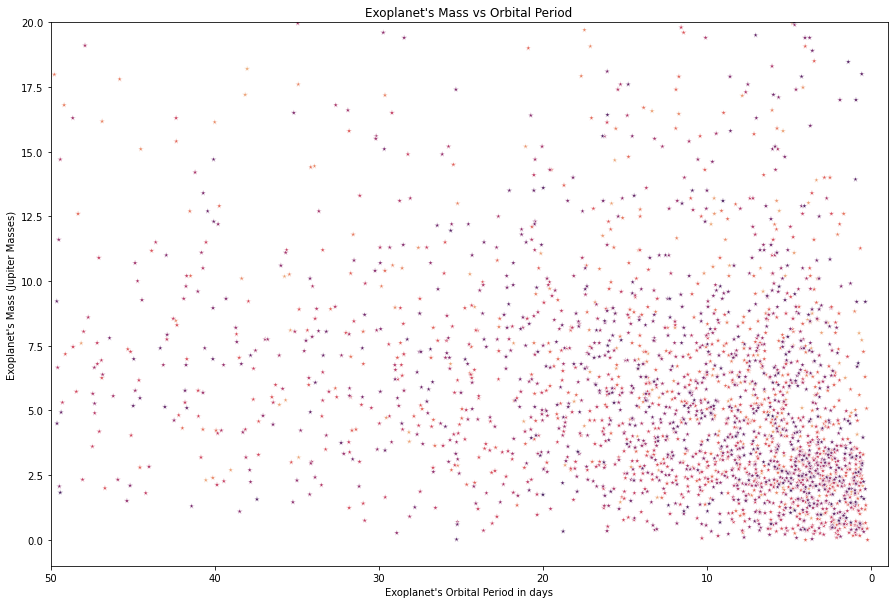

In [33]:
fig, ax = plt.subplots(figsize = (15,10))
sns.scatterplot(x = 'pl_orbper', y = 'pl_bmasse', data = exoplanet, marker = '*', hue = 'pl_orbper', palette = 'flare', legend=False)
ax.set_xlim(50, -1)
ax.set_ylim(-1, 20)
ax.set_title("Exoplanet's Mass vs Orbital Period")
ax.set_xlabel("Exoplanet's Orbital Period in days")
ax.set_ylabel("Exoplanet's Mass (Jupiter Masses)");

# Using KMeans Clustering to Determine 

In [73]:
features = ['pl_orbper', 'pl_bmasse']

In [74]:
type_exoplanets = exoplanet[features]

In [82]:
scaler = StandardScaler()
scaled_exo = scaler.fit_transform(exoplanet)

In [83]:
from sklearn.cluster import KMeans

In [84]:
# We create 4 types of clusters based on NASA exoplanet groups
# 1. Terrestial
# 2. Super Earth's 
# 3. Neptunian 
# 4. Gas Giant's 
k_means = KMeans(n_clusters=4)
k_means.fit(scaled_exo)
cluster_assignments = k_means.predict(scaled_exo) 

In [85]:
type_planets = dict(zip(pl_names, cluster_assignments))

In [86]:
pd.Series(type_planets.values()).value_counts()

0    3060
1    1305
3       1
2       1
dtype: int64

In [62]:
print(calinski_harabasz_score(exoplanet, cluster_assignments))

510530.4184924482


In [63]:
k_means_2 = KMeans(n_clusters = 2).fit(exoplanet)
k_means_3 = KMeans(n_clusters = 3).fit(exoplanet)
k_means_4 = KMeans(n_clusters = 4).fit(exoplanet)
k_means_5 = KMeans(n_clusters = 5).fit(exoplanet)
k_means_6 = KMeans(n_clusters = 6).fit(exoplanet)

k_list = [k_means_2, k_means_3, k_means_4, k_means_5, k_means_6]

In [64]:
CH_score = []

for model in k_list:
    labels = model.labels_
    CH_score.append(calinski_harabasz_score(exoplanet, labels))

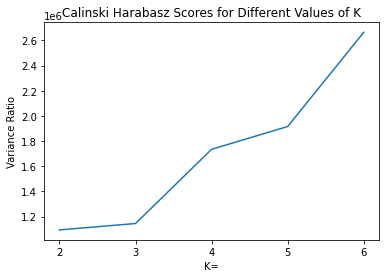

In [65]:
plt.plot([2, 3, 4, 5, 6], CH_score)
plt.xticks([2,3,4,5,6])
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [66]:
wcss_score = []

for model in k_list:
    labels = model.labels_
    wcss_score.append(model.inertia_)

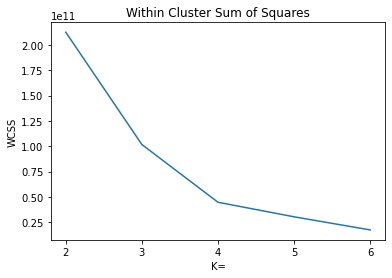

In [67]:
plt.plot([2, 3, 4, 5, 6], wcss_score)
plt.xticks([2,3,4,5,6])
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

In [68]:
SH_score = []

for model in k_list:
    labels = model.labels_
    SH_score.append(metrics.silhouette_score(exoplanet, labels))

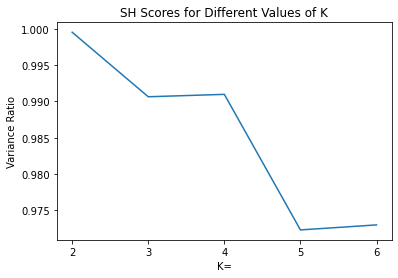

In [69]:
plt.plot([2, 3, 4, 5, 6], SH_score)
plt.xticks([2,3,4,5,6])
plt.title('SH Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()